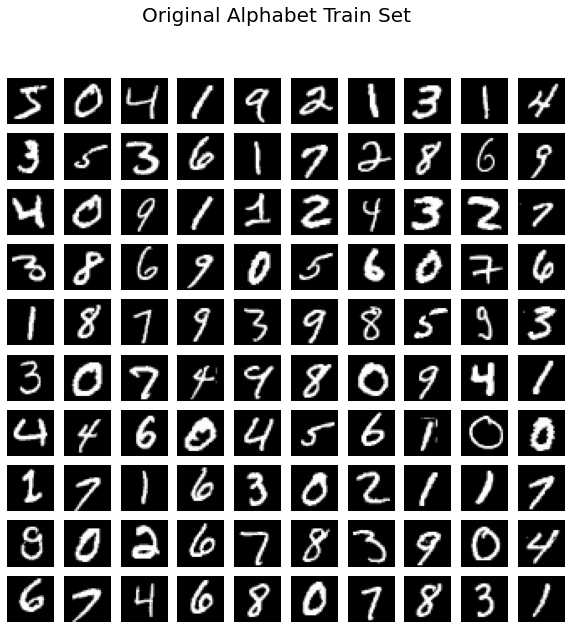

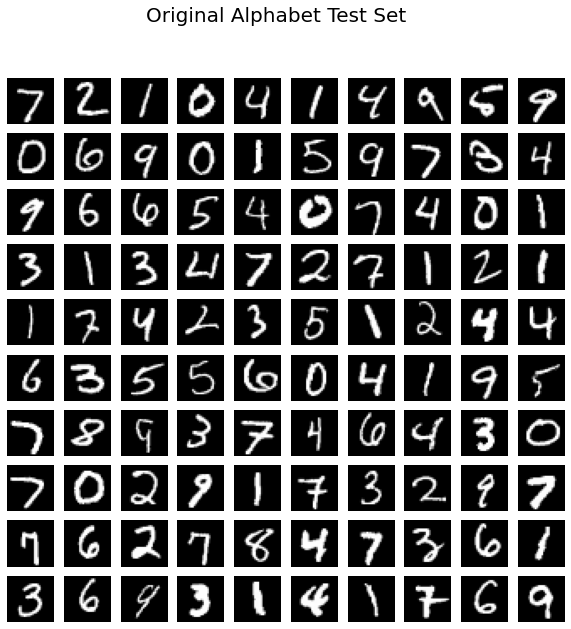

In [12]:
import matplotlib.pyplot as plt
from keras.datasets import mnist

##  Reference links to aid with project

#   https://medium.com/ml-everything/generating-letters-using-generative-adversarial-networks-gans-161b0be3c229
#   https://github.com/breeko/gans-in-action/blob/master/ch3_gan_emnist.ipynb

#   https://towardsdatascience.com/alphabet-gan-ai-generates-english-letters-589637068808
#   https://github.com/Suji04/NormalizedNerd/blob/master/Alphabet%20GAN/english-alphabet-gan.ipynb

#   https://www.kaggle.com/sachinpatel21/az-handwritten-alphabets-in-csv-format

##  Loading the dataset into a train, test split format

(x_train, y_train), (x_test, y_test) = mnist.load_data()

##  Define the dimensions for the image data
width, height, channel = 28, 28, 1

##  Define a function to visualise the data as an image
def visualise_data(data, title=""):
    plt.figure(figsize=(10, 10))

    counter = 1
    for item in data:
        plt.subplot(10, 10, counter)
        plt.imshow(item.reshape((height, width)), cmap='gray')
        plt.axis('off')
        counter += 1
        if counter > 100: break

    plt.suptitle(title, fontsize=20)
    plt.show()

##  Visualise the training and testing sets
visualise_data(x_train, title="Original MNIST Digit Train Set")
visualise_data(x_test, title="Original MNIST Digit Test Set")